In [6]:
%load_ext autoreload
%autoreload 2

import sys, os
import numpy as np
import matplotlib.pyplot as plt
from pydrake.all import StartMeshcat

# Ensure repo root is in path
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

meshcat = StartMeshcat()
print("Meshcat URL:", meshcat.web_url())

INFO:drake:Meshcat listening for connections at http://localhost:7004


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Meshcat URL: http://localhost:7004


### Imports and Helper Functions
We define the geometry helpers (transforms) and blocking logic here.

In [7]:
from pydrake.multibody.tree import RevoluteJoint
from rocky.build import build_robot_diagram_two
from rocky.ilqr import ILQRController, CostParams
from rocky.dynamics import ArmParams, forward_kinematics
from rocky.collocation import CollocationDefender  # <--- YOUR NEW CONTROLLER

rng = np.random.default_rng()

# --------------------------------------------------------------------
# Geometry / Transform Helpers
# --------------------------------------------------------------------

def get_shoulder_in_world(plant, ctx, wall_frame):
    X_W_wall = plant.CalcRelativeTransform(ctx, W, wall_frame)
    shoulder_in_wall = np.array([0.0, 0.0, 1.0])   # joint origin in wall frame
    return X_W_wall.translation() + X_W_wall.rotation().matrix() @ shoulder_in_wall

def express_point_in_wall_2d(plant, ctx, wall_frame, p_W_point, p_W_shoulder):
    # Transform point into wall frame to get local (x, z)
    X_wall_W = plant.CalcRelativeTransform(ctx, wall_frame, W)
    p_wall_point = X_wall_W.multiply(p_W_point)
    p_wall_shoulder = X_wall_W.multiply(p_W_shoulder)
    rel = p_wall_point - p_wall_shoulder
    return np.array([rel[0], rel[2]])

def get_ally_shoulder_in_world(plant, ctx):
    return get_shoulder_in_world(plant, ctx, ally_wall_frame)

def get_enemy_shoulder_in_world(plant, ctx):
    return get_shoulder_in_world(plant, ctx, enemy_wall_frame)

# --- Ally's View (Ally Wall Frame) ---
def get_ally_target_pos_2d(plant, ctx):
    p_W_shoulder = get_ally_shoulder_in_world(plant, ctx)
    p_W_T = plant.CalcRelativeTransform(ctx, W, enemy_target_frame).translation()
    return express_point_in_wall_2d(plant, ctx, ally_wall_frame, p_W_T, p_W_shoulder)

def get_enemy_pos_2d(plant, ctx):
    # Enemy EE in Ally frame (for blocking)
    p_W_shoulder = get_ally_shoulder_in_world(plant, ctx)
    p_W_EE = plant.CalcRelativeTransform(ctx, W, enemy_glove_frame).translation()
    return express_point_in_wall_2d(plant, ctx, ally_wall_frame, p_W_EE, p_W_shoulder)

def get_enemy_target_pos_2d_for_ally(plant, ctx):
    # The point the enemy is trying to hit (near Ally), in Ally frame
    p_W_shoulder = get_ally_shoulder_in_world(plant, ctx)
    p_W_T = plant.CalcRelativeTransform(ctx, W, ally_target_frame).translation()
    return express_point_in_wall_2d(plant, ctx, ally_wall_frame, p_W_T, p_W_shoulder)

# --- Enemy's View (Enemy Wall Frame) ---
def get_enemy_target_pos_2d_for_enemy(plant, ctx):
    p_W_shoulder = get_enemy_shoulder_in_world(plant, ctx)
    p_W_T = plant.CalcRelativeTransform(ctx, W, ally_target_frame).translation()
    return express_point_in_wall_2d(plant, ctx, enemy_wall_frame, p_W_T, p_W_shoulder)

def get_ally_pos_2d_for_enemy(plant, ctx):
    p_W_shoulder = get_enemy_shoulder_in_world(plant, ctx)
    p_W_ally = plant.CalcRelativeTransform(ctx, W, ally_glove_frame).translation()
    return express_point_in_wall_2d(plant, ctx, enemy_wall_frame, p_W_ally, p_W_shoulder)

def get_enemy_pos_2d_for_enemy(plant, ctx):
    p_W_shoulder = get_enemy_shoulder_in_world(plant, ctx)
    p_W_enemy = plant.CalcRelativeTransform(ctx, W, enemy_glove_frame).translation()
    return express_point_in_wall_2d(plant, ctx, enemy_wall_frame, p_W_enemy, p_W_shoulder)

# --- State Helpers ---
def get_ally_state(plant, ctx, ally):
    q = plant.GetPositions(ctx, ally)[:2]
    dq = plant.GetVelocities(ctx, ally)[:2]
    return np.hstack([q, dq])

def get_enemy_state(plant, ctx, enemy):
    q = plant.GetPositions(ctx, enemy)[:2]
    dq = plant.GetVelocities(ctx, enemy)[:2]
    return np.hstack([q, dq])

def get_ally_pos_2d_from_model(x, params):
    return forward_kinematics(x[:2], params)

# --- Blocking Logic ---
def get_block_point_2d(enemy_ee_2d, enemy_target_2d, lam=0.5):
    # Interpolate between enemy fist and their target
    return enemy_ee_2d + lam * (enemy_target_2d - enemy_ee_2d)

def clamp_radius(p, r_min, r_max):
    # Keep blocking point within reachable workspace
    r = np.linalg.norm(p)
    if r < 1e-6: return p
    r_clamped = np.clip(r, r_min, r_max)
    return p * (r_clamped / r)

def has_hit_target(pos, target, R_target=0.1, R_ee=0.005):
    return np.linalg.norm(pos - target) <= (R_target + R_ee)


### Build Simulation and Initialize Controllers

In [21]:
# URDF Path (Adjust if necessary)
urdf = "../rocky.urdf"
if not os.path.exists(urdf):
    # Fallback for explicit path if running deep in directories
    urdf = "/home/para/RoboRocky/rocky.urdf"

# --- Build Simulation ---
bundle = build_robot_diagram_two(
    urdf_path=urdf,
    time_step=1e-3,
    gravity_vec=(0., 0., 0.),
    meshcat=meshcat,
    disable_link_collisions=True,
)

plant, ctx, sim = bundle.plant, bundle.plant_context, bundle.simulator
ally, enemy = bundle.ally, bundle.enemy

# Cache Frames
W = plant.world_frame()
enemy_target_frame = plant.GetFrameByName("enemy_target")
ally_target_frame  = plant.GetFrameByName("ally_target")
ally_wall_frame   = plant.GetFrameByName("wall", model_instance=ally)
ally_glove_frame  = plant.GetFrameByName("glove", model_instance=ally)
enemy_wall_frame  = plant.GetFrameByName("wall", model_instance=enemy)
enemy_elbow_frame = plant.GetFrameByName("elbow_marker", model_instance=enemy)
enemy_glove_frame = plant.GetFrameByName("glove", model_instance=enemy)

ally_act_idxs = list(plant.GetJointActuatorIndices(ally))
enemy_act_idxs = list(plant.GetJointActuatorIndices(enemy))

# --- Params & Costs ---
params = ArmParams()
enemy_params = ArmParams(torque_limit=np.array([1.5, 1.5])) # Weaker enemy

cost = CostParams(
    Q=np.diag([2.0, 2.0, 0.1, 0.1]),
    R=0.01 * np.eye(2),
    Qf=np.diag([50.0, 50.0, 1.0, 1.0]),
    target_weight=425.0,
    r_min=0.01,
    avoid_weight=30.0,
    avoid_sigma=0.08,
)

# --- Controllers ---

# 1. Ally Attacker (Phase 1)
ally_attack_ctrl = ILQRController(horizon=50, dt=0.02, params=params, cost=cost, verbose=False)

# 2. Enemy Attacker (Phase 2)
enemy_ctrl = ILQRController(
    horizon=50, dt=0.02, params=enemy_params,
    cost=CostParams(
        target_weight=425.0, 
        avoid_weight=10.0, 
        avoid_sigma=0.08
    )
)

# 3. Ally Defender (Phase 2) -> COLLOCATION
# Note: num_time_samples=15 allows for fast solves (~30-50ms)
ally_defender = CollocationDefender(urdf, num_time_samples=15, time_horizon=0.4)

# Cell 3: Setup Code
# ... [imports and URDF setup remain the same] ...

# --- Initial Configuration Helper (Fixed) ---
def set_angles(inst, angles):
    # Only increment the angle index when we actually set a revolute joint
    angle_idx = 0
    for j_idx in plant.GetJointIndices(inst):
        joint = plant.get_joint(j_idx)
        if isinstance(joint, RevoluteJoint):
            # Safety check to prevent index errors if URDF changes
            if angle_idx < len(angles):
                joint.set_angle(ctx, angles[angle_idx])
                angle_idx += 1

# Set start angles
ally_start = np.deg2rad([45.0, -130.0])
enemy_start = np.deg2rad([70.0, -160.0])

set_angles(ally, ally_start)
set_angles(enemy, enemy_start)

def apply_combined_torques(u_ally=None, u_enemy=None):
    tau = np.zeros(plant.num_actuators())
    if u_ally is not None:
        tau[ally_act_idxs[0]] = u_ally[0]
        tau[ally_act_idxs[1]] = u_ally[1]
    if u_enemy is not None:
        tau[enemy_act_idxs[0]] = u_enemy[0]
        tau[enemy_act_idxs[1]] = u_enemy[1]
    plant.get_actuation_input_port().FixValue(ctx, tau)

sim.AdvanceTo(0.0)
print("Ready to simulate.")

Ready to simulate.


### Run Simulation Loop
Runs Phase 1 (Attack) then Phase 2 (Defense with Collocation).

In [26]:
# Logging
t_log, ally_pos_log, enemy_pos_log, block_pos_log = [], [], [], []
ally_u_log, enemy_u_log, phase_log = [], [], []

meshcat.DeleteRecording()
meshcat.StartRecording()

# ================= PHASE 1: ALLY ATTACK =================
print("Phase 1: Ally attacks, enemy passive...")
ally_attack_duration = 6.0
phase1_end = sim.get_context().get_time() + ally_attack_duration
ally_u_prev = None
ally_hit = False

while sim.get_context().get_time() < phase1_end:
    t = sim.get_context().get_time()
    
    # State
    x_ally = get_ally_state(plant, ctx, ally)
    target_pos = get_ally_target_pos_2d(plant, ctx)
    enemy_pos_for_ally = get_enemy_pos_2d(plant, ctx)
    ally_ee = get_ally_pos_2d_from_model(x_ally, params)

    if has_hit_target(ally_ee, target_pos):
        ally_hit = True
        ally_u = np.zeros(2)
    elif ally_hit:
        ally_u = np.zeros(2)
    else:
        # iLQR Attack
        _, res = ally_attack_ctrl.step_mpc(
            x_ally, target_pos, enemy_pos_for_ally, ally_u_prev
        )
        if res.converged:
            ally_u_prev = res.u_trj
            ally_u = res.u_trj[0]
        else:
            ally_u = params.clip_u(-2.0 * x_ally[2:]) # Damping fallback

    apply_combined_torques(u_ally=ally_u, u_enemy=np.zeros(2))
    sim.AdvanceTo(t + 0.02)
    
    # Log
    t_log.append(t)
    ally_pos_log.append(ally_ee)
    enemy_pos_log.append(enemy_pos_for_ally)
    block_pos_log.append([np.nan, np.nan])
    ally_u_log.append(ally_u)
    enemy_u_log.append(np.zeros(2))
    phase_log.append(1)
    
    if ally_hit: break

# Reset controls
apply_combined_torques(np.zeros(2), np.zeros(2))

# ================= PHASE 2: ALLY DEFEND (Collocation) =================
print("Phase 2: Enemy attacks, Ally defends (Collocation)...")
enemy_attack_duration = 4.0
phase2_end = sim.get_context().get_time() + enemy_attack_duration
enemy_u_prev = None
enemy_hit = False

# Params for Blocking Point
L1, L2 = 0.5, 0.5
r_max_block = 0.95 * (L1 + L2)
r_min_block = 0.20
defense_step_dt = 0.05 # Re-plan every 50ms

while sim.get_context().get_time() < phase2_end:
    t = sim.get_context().get_time()
    
    # --- 1. Enemy Attack Logic (iLQR) ---
    x_enemy = get_enemy_state(plant, ctx, enemy)
    # Target for enemy is Ally's "ally_target" frame
    en_target_local = get_enemy_target_pos_2d_for_enemy(plant, ctx)
    ally_pos_local = get_ally_pos_2d_for_enemy(plant, ctx)
    
    en_ee_local = get_enemy_pos_2d_for_enemy(plant, ctx)
    if has_hit_target(en_ee_local, en_target_local):
        enemy_hit = True
        
    if enemy_hit:
        u_enemy = np.zeros(2)
    else:
        _, res_e = enemy_ctrl.step_mpc(
            x_enemy, en_target_local, ally_pos_local, enemy_u_prev
        )
        if res_e.converged:
            enemy_u_prev = res_e.u_trj
            u_enemy = res_e.u_trj[0]
        else:
            u_enemy = enemy_params.clip_u(-2.0 * x_enemy[2:])

    # --- 2. Ally Defense Logic (Collocation) ---
    x_ally = get_ally_state(plant, ctx, ally)
    
    # Get blocking target in Ally Frame
    enemy_pos_ally = get_enemy_pos_2d(plant, ctx)
    enemy_target_ally = get_enemy_target_pos_2d_for_ally(plant, ctx)
    
    # Calculate Interpolated Blocking Point
    dist_ET = np.linalg.norm(enemy_target_ally - enemy_pos_ally)
    # As enemy gets closer, block closer to target (lam -> 1.0)
    lam = 0.4 + 0.5 * np.tanh(2.0 * (0.8 - dist_ET)) 
    
    raw_block = get_block_point_2d(enemy_pos_ally, enemy_target_ally, lam)
    block_pos = clamp_radius(raw_block, r_min_block, r_max_block)
    
    # *** CALL COLLOCATION DEFENDER ***
    u_ally_col, res_col = ally_defender.plan(x_ally, block_pos)
    
    if res_col.is_success():
        u_ally = u_ally_col
    else:
        # Fallback damping if solver fails
        u_ally = params.clip_u(-5.0 * x_ally[2:])

    # Apply & Step
    apply_combined_torques(u_ally, u_enemy)
    sim.AdvanceTo(t + defense_step_dt)
    
    # Log
    t_log.append(t)
    ally_pos_log.append(get_ally_pos_2d_from_model(x_ally, params))
    enemy_pos_log.append(enemy_pos_ally)
    block_pos_log.append(block_pos)
    ally_u_log.append(u_ally)
    enemy_u_log.append(u_enemy)
    phase_log.append(2)

    if enemy_hit: break

apply_combined_torques(np.zeros(2), np.zeros(2))
meshcat.StopRecording()
meshcat.PublishRecording()
print("Simulation Complete.")

Phase 1: Ally attacks, enemy passive...
Phase 2: Enemy attacks, Ally defends (Collocation)...


/home/para/RoboRocky/rocky/ilqr.py:135: RuntimeWarning: overflow encountered in matmul
  l += 0.5 * dx.T @ cost.Q @ dx + 0.5 * u.T @ cost.R @ u
/home/para/RoboRocky/rocky/dynamics.py:94: RuntimeWarning: overflow encountered in matmul
  ddq = np.linalg.solve(M, u_clipped - C @ dq - G - damping)


AttributeError: 'pydrake.planning.DirectCollocation' object has no attribute 'AddInputBounds'

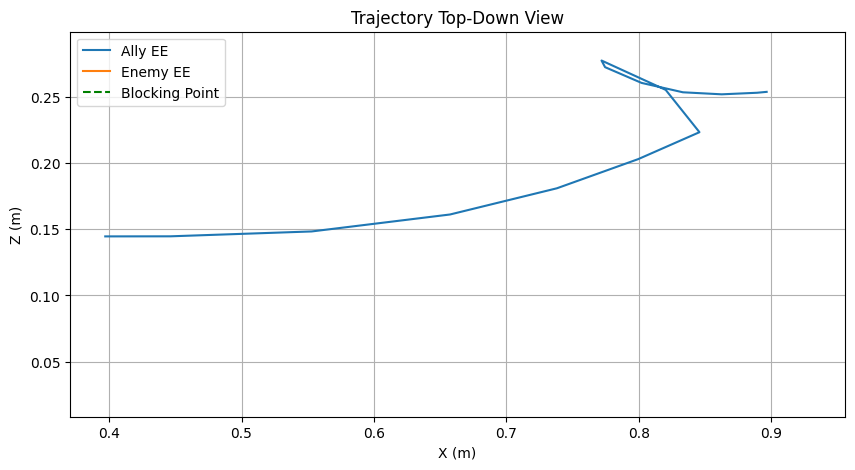

In [23]:
# --- Visualization ---
t_arr = np.array(t_log)
ally_pos = np.array(ally_pos_log)
enemy_pos = np.array(enemy_pos_log)
block_pos = np.array(block_pos_log)

plt.figure(figsize=(10,5))
plt.plot(ally_pos[:,0], ally_pos[:,1], label="Ally EE")
plt.plot(enemy_pos[:,0], enemy_pos[:,1], label="Enemy EE")

# Only plot blocking points for Phase 2
phase_arr = np.array(phase_log)
mask_p2 = (phase_arr == 2)
plt.plot(block_pos[mask_p2, 0], block_pos[mask_p2, 1], 'g--', label="Blocking Point")

plt.title("Trajectory Top-Down View")
plt.xlabel("X (m)")
plt.ylabel("Z (m)")
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()